In [1]:
import sklearn
import pandas as pd
import numpy as np
from __future__ import division
import collections
from sklearn.cross_validation import train_test_split
from sklearn import svm
from sklearn.svm import SVC
from sklearn import linear_model
from sklearn import tree
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Convolution1D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import SGD
from sklearn.cross_validation import cross_val_score
from keras.utils import np_utils
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import sys
from sklearn.ensemble import GradientBoostingRegressor
import math
import csv
%matplotlib inline
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report
import urllib

Using TensorFlow backend.


# Visualizing All the Historical Data

Let's first take a look at all the historical data we have. These are stats from the 1985 - 2015 NCAA basketball seasons. 

In [2]:
# This one contains stats for every single regular season game played between 1985 and 2015. It mainly
# contains info on the score of the game, the IDs for each team, and where the game was played.
reg_season_compact_pd = pd.read_csv('RegularSeasonCompactResults.csv')
reg_season_compact_pd.head()

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0


In [3]:
# This one expands on the previous data frame by going into more in depth stats like 3 point field goals,
# free throws, steals, blocks, etc. 
reg_season_detailed_pd = pd.read_csv('RegularSeasonDetailedResults.csv')
reg_season_detailed_pd.columns

Index([u'Season', u'Daynum', u'Wteam', u'Wscore', u'Lteam', u'Lscore', u'Wloc',
       u'Numot', u'Wfgm', u'Wfga', u'Wfgm3', u'Wfga3', u'Wftm', u'Wfta',
       u'Wor', u'Wdr', u'Wast', u'Wto', u'Wstl', u'Wblk', u'Wpf', u'Lfgm',
       u'Lfga', u'Lfgm3', u'Lfga3', u'Lftm', u'Lfta', u'Lor', u'Ldr', u'Last',
       u'Lto', u'Lstl', u'Lblk', u'Lpf'],
      dtype='object')

In [4]:
# Don't think this data is honestly that important. Just contains the region areas for the tournament each 
# year. There isn't really a distinct "home field" advantage in the tourney because the games are supposed
# to be on neutral sites. 
seasons_pd = pd.read_csv('Seasons.csv')
seasons_pd.head()

,Season,Dayzero,Regionw,Regionx,Regiony,Regionz
0,1985,10/29/1984,East,West,Midwest,Southeast
1,1986,10/28/1985,East,Midwest,Southeast,West
2,1987,10/27/1986,East,Southeast,Midwest,West
3,1988,11/2/1987,East,Midwest,Southeast,West
4,1989,10/31/1988,East,West,Midwest,Southeast


In [5]:
teams_pd = pd.read_csv('Teams.csv')
teamList = teams_pd['Team_Name'].tolist()
teams_pd.tail()

,Team_Id,Team_Name
359,1460,Wright St
360,1461,Wyoming
361,1462,Xavier
362,1463,Yale
363,1464,Youngstown St


In [6]:
# Print UCLA
print teams_pd[teams_pd['Team_Name'] == 'UCLA']

     Team_Id Team_Name
316     1417      UCLA


In [7]:
# This one contains the stats for every single NCAA tournament game from 1985 to 2015
tourney_compact_pd = pd.read_csv('TourneyCompactResults.csv')
tourney_compact_pd.head()

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0


In [8]:
# More deatiled tourney stats (except only stats from 2003 :( )
tourney_detailed_pd = pd.read_csv('TourneyDetailedResults.csv')
tourney_detailed_pd.head()

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot,Wfgm,Wfga,...,Lfga3,Lftm,Lfta,Lor,Ldr,Last,Lto,Lstl,Lblk,Lpf
0,2003,134,1421,92,1411,84,N,1,32,69,...,31,14,31,17,28,16,15,5,0,22
1,2003,136,1112,80,1436,51,N,0,31,66,...,16,7,7,8,26,12,17,10,3,15
2,2003,136,1113,84,1272,71,N,0,31,59,...,28,14,21,20,22,11,12,2,5,18
3,2003,136,1141,79,1166,73,N,0,29,53,...,17,12,17,14,17,20,21,6,6,21
4,2003,136,1143,76,1301,74,N,1,27,64,...,21,15,20,10,26,16,14,5,8,19


In [9]:
# This one tells you what seed each team was for a given tournament year
tourney_seeds_pd = pd.read_csv('TourneySeeds.csv')
tourney_seeds_pd.head()

,Season,Seed,Team
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [10]:
# Seeing what seed Duke was in every tourney
duke_id = teams_pd[teams_pd['Team_Name'] == 'Duke'].values[0][0]
tourney_seeds_pd[tourney_seeds_pd['Team'] == duke_id]

,Season,Seed,Team
34,1985,Y03,1181
64,1986,W01,1181
164,1987,Y05,1181
193,1988,W02,1181
257,1989,W02,1181
322,1990,W03,1181
417,1991,Y02,1181
448,1992,W01,1181
530,1993,X03,1181
593,1994,X02,1181


In [11]:
# Don't know how helpful this is tbh, because it just tells you what the seeds of the stronger
# and weaker seeds are (assuming that the favored team wins??), so its always 1 vs 16 and then 
# 1 vs 8 and 1 vs 4..
tourney_slots_pd = pd.read_csv('TourneySlots.csv')
tourney_slots_pd.head()

,Season,Slot,Strongseed,Weakseed
0,1985,R1W1,W01,W16
1,1985,R1W2,W02,W15
2,1985,R1W3,W03,W14
3,1985,R1W4,W04,W13
4,1985,R1W5,W05,W12


In [12]:
conference_pd = pd.read_csv('Conference.csv')
conference_pd.head()

,Year,Conference,Schls,W,L,W-L%,SRS,SOS,AP,NCAA,FF,Regular Season Champ,Tournament Champ
0,2003,Southeastern Conference,12,220,145,0.603,12.95,8.58,4,6,0,Kentucky (East) Mississippi St (West),Kentucky
1,2003,Big 12 Conference,12,238,146,0.620,12.94,8.21,4,6,2,Kansas,Oklahoma
2,2003,Atlantic Coast Conference,9,170,111,0.605,12.75,7.83,3,4,0,Wake Forest,Duke
3,2003,Big East Conference,14,262,179,0.594,11.03,7.13,4,4,1,Boston College (East) Connecticut (East) Pitts...,Pittsburgh
4,2003,Big Ten Conference,11,200,146,0.578,10.68,7.66,2,5,0,Wisconsin,Illinois


In [13]:
tourney_results_pd = pd.read_csv('TourneyResults.csv')
tourney_results_pd.head()
NCAAChampionsList = tourney_results_pd['NCAA Champion'].tolist()

# Feature Selection

Let's make this supervised trianing problem where our model with take in 2 d dimensional vectors, representing the two teams playing in the tournament. Each d dimensional vector will contain information about the team for that year. Below are the features we end up using. 

* Regular Season Wins 
* Points per game season average 
* Points per game allowed season average
* Whether or not in Power 6 conference (ACC, Big Ten, Big 12, SEC, Pac 12, Big East) - Binary label
* Number of 3's per game
* Turnovers per game average
* Assists per game average
* Conference Championship - binary label
* Conference Tournament Championship - binary label
* Tournament Seed
* Strength of Schedule
* Simple Rating System
* Rebounds per game average
* Steals per game average
* Number of NCAA appearances since 1985
* Whether the team is home or away or neutral (labels -1, 0, and 1)

# Functions To Help Feature Selection

These functions help us obtain all the information that will eventually go in our team vectors. 

In [14]:
listACCteams = ['North Carolina','Virginia','Florida St','Louisville','Notre Dame','Syracuse','Duke','Virginia Tech','Georgia Tech','Miami','Wake Forest','Clemson','NC State','Boston College','Pittsburgh']
listPac12teams = ['Arizona','Oregon','UCLA','California','USC','Utah','Washington St','Stanford','Arizona St','Colorado','Washington','Oregon St']
listSECteams = ['Kentucky','South Carolina','Florida','Arkansas','Alabama','Tennessee','Mississippi St','Georgia','Ole Miss','Vanderbilt','Auburn','Texas A&M','LSU','Missouri']
listBig10teams = ['Maryland','Wisconsin','Purdue','Northwestern','Michigan St','Indiana','Iowa','Michigan','Penn St','Nebraska','Minnesota','Illinois','Ohio St','Rutgers']
listBig12teams = ['Kansas','Baylor','West Virginia','Iowa St','TCU','Kansas St','Texas Tech','Oklahoma St','Texas','Oklahoma']
listBigEastteams = ['Butler','Creighton','DePaul','Georgetown','Marquette','Providence','Seton Hall','St John\'s','Villanova','Xavier']

In [15]:
def checkPower6Conference(team_id):
    teamName = teams_pd.values[team_id-1101][1]
    if (teamName in listACCteams or teamName in listBig10teams or teamName in listBig12teams
       or teamName in listSECteams or teamName in listPac12teams or teamName in listBigEastteams):
        return 1
    else:
        return 0

In [16]:
def getTeamID(name):
    return teams_pd[teams_pd['Team_Name'] == name].values[0][0]

In [17]:
def getTeamName(team_id):
    return teams_pd[teams_pd['Team_Id'] == team_id].values[0][1]

In [18]:
def getNumChampionships(team_id):
    name = getTeamName(team_id)
    return NCAAChampionsList.count(name)

In [19]:
def getListForURL(team_list):
    team_list = [x.lower() for x in team_list]
    team_list = [t.replace(' ', '-') for t in team_list]
    team_list = [t.replace('st', 'state') for t in team_list]
    team_list = [t.replace('northern-dakota', 'north-dakota') for t in team_list]
    team_list = [t.replace('nc-', 'north-carolina-') for t in team_list]
    team_list = [t.replace('fl-', 'florida-') for t in team_list]
    team_list = [t.replace('ga-', 'georgia-') for t in team_list]
    team_list = [t.replace('lsu', 'louisiana-state') for t in team_list]
    team_list = [t.replace('maristate', 'marist') for t in team_list]
    team_list = [t.replace('stateate', 'state') for t in team_list]
    team_list = [t.replace('northernorthern', 'northern') for t in team_list]
    team_list = [t.replace('usc', 'southern-california') for t in team_list]
    base = 'http://www.sports-reference.com/cbb/schools/'
    for team in team_list:
        url = base + team + '/'
getListForURL(teamList);

In [20]:
def handleCases(arr):
    indices = []
    listLen = len(arr)
    for i in range(listLen):
        if (arr[i] == 'St' or arr[i] == 'FL'):
            indices.append(i)
    for p in indices:
        arr[p-1] = arr[p-1] + ' ' + arr[p]
    for i in range(len(indices)): 
        arr.remove(arr[indices[i] - i])
    return arr

In [21]:
def checkConferenceChamp(team_id, year):
    year_conf_pd = conference_pd[conference_pd['Year'] == year]
    champs = year_conf_pd['Regular Season Champ'].tolist()
    # For handling cases where there is more than one champion
    champs_separated = [words for segments in champs for words in segments.split()]
    name = getTeamName(team_id)
    champs_separated = handleCases(champs_separated)
    if (name in champs_separated):
        return 1
    else:
        return 0

In [22]:
def checkConferenceTourneyChamp(team_id, year):
    year_conf_pd = conference_pd[conference_pd['Year'] == year]
    champs = year_conf_pd['Tournament Champ'].tolist()
    name = getTeamName(team_id)
    if (name in champs):
        return 1
    else:
        return 0

In [23]:
def getTourneyAppearances(team_id):
    return len(tourney_seeds_pd[tourney_seeds_pd['Team'] == team_id].index)

In [24]:
def handleDifferentCSV(df):
    # The stats CSV is a lit different in terms of naming so below is just some data cleaning
    df['School'] = df['School'].replace('(State)', 'St', regex=True) 
    df['School'] = df['School'].replace('Albany (NY)', 'Albany NY') 
    df['School'] = df['School'].replace('Boston University', 'Boston Univ')
    df['School'] = df['School'].replace('Central Michigan', 'C Michigan')
    df['School'] = df['School'].replace('(Eastern)', 'E', regex=True)
    df['School'] = df['School'].replace('Louisiana St', 'LSU')
    df['School'] = df['School'].replace('North Carolina St', 'NC State')
    df['School'] = df['School'].replace('Southern California', 'USC')
    df['School'] = df['School'].replace('University of California', 'California', regex=True) 
    df['School'] = df['School'].replace('American', 'American Univ')
    df['School'] = df['School'].replace('Arkansas-Little Rock', 'Ark Little Rock')
    df['School'] = df['School'].replace('Arkansas-Pine Bluff', 'Ark Pine Bluff')
    df['School'] = df['School'].replace('Bowling Green St', 'Bowling Green')
    df['School'] = df['School'].replace('Brigham Young', 'BYU')
    df['School'] = df['School'].replace('Cal Poly', 'Cal Poly SLO')
    df['School'] = df['School'].replace('Centenary (LA)', 'Centenary')
    df['School'] = df['School'].replace('Central Connecticut St', 'Central Conn')
    df['School'] = df['School'].replace('Charleston Southern', 'Charleston So')
    df['School'] = df['School'].replace('Coastal Carolina', 'Coastal Car')
    df['School'] = df['School'].replace('College of Charleston', 'Col Charleston')
    df['School'] = df['School'].replace('Cal St Fullerton', 'CS Fullerton')
    df['School'] = df['School'].replace('Cal St Sacramento', 'CS Sacramento')
    df['School'] = df['School'].replace('Cal St Bakersfield', 'CS Bakersfield')
    df['School'] = df['School'].replace('Cal St Northridge', 'CS Northridge')
    df['School'] = df['School'].replace('East Tennessee St', 'ETSU')
    df['School'] = df['School'].replace('Detroit Mercy', 'Detroit')
    df['School'] = df['School'].replace('Fairleigh Dickinson', 'F Dickinson')
    df['School'] = df['School'].replace('Florida Atlantic', 'FL Atlantic')
    df['School'] = df['School'].replace('Florida Gulf Coast', 'FL Gulf Coast')
    df['School'] = df['School'].replace('Florida International', 'Florida Intl')
    df['School'] = df['School'].replace('George Washington', 'G Washington')
    df['School'] = df['School'].replace('Georgia Southern', 'Ga Southern')
    df['School'] = df['School'].replace('Gardner-Webb', 'Gardner Webb')
    df['School'] = df['School'].replace('Illinois-Chicago', 'IL Chicago')
    df['School'] = df['School'].replace('Kent St', 'Kent')
    df['School'] = df['School'].replace('Long Island University', 'Long Island')
    df['School'] = df['School'].replace('Loyola Marymount', 'Loy Marymount')
    df['School'] = df['School'].replace('Loyola (MD)', 'Loyola MD')
    df['School'] = df['School'].replace('Loyola (IL)', 'Loyola-Chicago')
    df['School'] = df['School'].replace('Massachusetts', 'MA Lowell')
    df['School'] = df['School'].replace('Maryland-Eastern Shore', 'MD E Shore')
    df['School'] = df['School'].replace('Miami (FL)', 'Miami FL')
    df['School'] = df['School'].replace('Miami (OH)', 'Miami OH')
    df['School'] = df['School'].replace('Missouri-Kansas City', 'Missouri KC')
    df['School'] = df['School'].replace('Monmouth', 'Monmouth NJ')
    df['School'] = df['School'].replace('Mississippi Valley St', 'MS Valley St')
    df['School'] = df['School'].replace('Montana St', 'MTSU')
    df['School'] = df['School'].replace('Northern Colorado', 'N Colorado')
    df['School'] = df['School'].replace('North Dakota St', 'N Dakota St')
    df['School'] = df['School'].replace('Northern Illinois', 'N Illinois')
    df['School'] = df['School'].replace('Northern Kentucky', 'N Kentucky')
    df['School'] = df['School'].replace('North Carolina A&T', 'NC A&T')
    df['School'] = df['School'].replace('North Carolina Central', 'NC Central')
    df['School'] = df['School'].replace('Pennsylvania', 'Penn')
    df['School'] = df['School'].replace('South Carolina St', 'S Carolina St')
    df['School'] = df['School'].replace('Southern Illinois', 'S Illinois')
    df['School'] = df['School'].replace('UC-Santa Barbara', 'Santa Barbara')
    df['School'] = df['School'].replace('Southeastern Louisiana', 'SE Louisiana')
    df['School'] = df['School'].replace('Southeast Missouri St', 'SE Missouri St')
    df['School'] = df['School'].replace('Stephen F. Austin', 'SF Austin')
    df['School'] = df['School'].replace('Southern Methodist', 'SMU')
    df['School'] = df['School'].replace('Southern Mississippi', 'Southern Miss')
    df['School'] = df['School'].replace('Southern', 'Southern Univ')
    df['School'] = df['School'].replace('St. Bonaventure', 'St Bonaventure')
    df['School'] = df['School'].replace('St. Francis (NY)', 'St Francis NY')
    df['School'] = df['School'].replace('Saint Francis (PA)', 'St Francis PA')
    df['School'] = df['School'].replace('St. John\'s (NY)', 'St John\'s')
    df['School'] = df['School'].replace('Saint Joseph\'s', 'St Joseph\'s PA')
    df['School'] = df['School'].replace('Saint Louis', 'St Louis')
    df['School'] = df['School'].replace('Saint Mary\'s (CA)', 'St Mary\'s CA')
    df['School'] = df['School'].replace('Mount Saint Mary\'s', 'Mt St Mary\'s')
    df['School'] = df['School'].replace('Saint Peter\'s', 'St Peter\'s')
    df['School'] = df['School'].replace('Texas A&M-Corpus Christian', 'TAM C. Christian')
    df['School'] = df['School'].replace('Texas Christian', 'TCU')
    df['School'] = df['School'].replace('Tennessee-Martin', 'TN Martin')
    df['School'] = df['School'].replace('Texas-Rio Grande Valley', 'UTRGV')
    df['School'] = df['School'].replace('Texas Southern', 'TX Southern')
    df['School'] = df['School'].replace('Alabama-Birmingham', 'UAB')
    df['School'] = df['School'].replace('UC-Davis', 'UC Davis')
    df['School'] = df['School'].replace('UC-Irvine', 'UC Irvine')
    df['School'] = df['School'].replace('UC-Riverside', 'UC Riverside')
    df['School'] = df['School'].replace('Central Florida', 'UCF')
    df['School'] = df['School'].replace('Louisiana-Lafayette', 'ULL')
    df['School'] = df['School'].replace('Louisiana-Monroe', 'ULM')
    df['School'] = df['School'].replace('Maryland-Baltimore County', 'UMBC')
    df['School'] = df['School'].replace('North Carolina-Asheville', 'UNC Asheville')
    df['School'] = df['School'].replace('North Carolina-Greensboro', 'UNC Greensboro')
    df['School'] = df['School'].replace('North Carolina-Wilmington', 'UNC Wilmington')
    df['School'] = df['School'].replace('Nevada-Las Vegas', 'UNLV')
    df['School'] = df['School'].replace('Texas-Arlington', 'UT Arlington')
    df['School'] = df['School'].replace('Texas-San Antonio', 'UT San Antonio')
    df['School'] = df['School'].replace('Texas-El Paso', 'UTEP')
    df['School'] = df['School'].replace('Virginia Commonwealth', 'VA Commonwealth')
    df['School'] = df['School'].replace('Western Carolina', 'W Carolina')
    df['School'] = df['School'].replace('Western Illinois', 'W Illinois')
    df['School'] = df['School'].replace('Western Kentucky', 'WKU')
    df['School'] = df['School'].replace('Western Michigan', 'W Michigan')
    df['School'] = df['School'].replace('Abilene Christian', 'Abilene Chr')
    df['School'] = df['School'].replace('Montana State', 'Montana St')
    df['School'] = df['School'].replace('Central Arkansas', 'Cent Arkansas')
    df['School'] = df['School'].replace('Houston Baptist', 'Houston Bap')
    df['School'] = df['School'].replace('South Dakota St', 'S Dakota St')
    df['School'] = df['School'].replace('Maryland-Eastern Shore', 'MD E Shore')
    return df

# Obtaining Season Vectors 

In [33]:
def getSeasonData(team_id, year):
    # The data frame below holds stats for every single game in the given year
    year_data_pd = reg_season_compact_pd[reg_season_compact_pd['Season'] == year]
    # Finding number of points per game
    gamesWon = year_data_pd[year_data_pd.Wteam == team_id] 
    totalPointsScored = gamesWon['Wscore'].sum()
    gamesLost = year_data_pd[year_data_pd.Lteam == team_id] 
    totalGames = gamesWon.append(gamesLost)
    numGames = len(totalGames.index)
    totalPointsScored += gamesLost['Lscore'].sum()
    
    # Finding number of points per game allowed
    totalPointsAllowed = gamesWon['Lscore'].sum()
    totalPointsAllowed += gamesLost['Wscore'].sum()
    
    stats_SOS_pd = pd.read_csv('MMStats/MMStats_'+str(year)+'.csv')
    stats_SOS_pd = handleDifferentCSV(stats_SOS_pd)
    ratings_pd = pd.read_csv('RatingStats/RatingStats_'+str(year)+'.csv')
    ratings_pd = handleDifferentCSV(ratings_pd)
    
    name = getTeamName(team_id)
    team = stats_SOS_pd[stats_SOS_pd['School'] == name]
    team_rating = ratings_pd[ratings_pd['School'] == name]
    if (len(team.index) == 0 or len(team_rating.index) == 0): #Can't find the team
        total3sMade = 0
        totalTurnovers = 0
        totalAssists = 0
        sos = 0
        totalRebounds = 0
        srs = 0
        totalSteals = 0
    else:
        total3sMade = team['X3P'].values[0]
        totalTurnovers = team['TOV'].values[0]
        if (math.isnan(totalTurnovers)):
            totalTurnovers = 0
        totalAssists = team['AST'].values[0]
        if (math.isnan(totalAssists)):
            totalAssists = 0
        sos = team['SOS'].values[0]
        srs = team['SRS'].values[0]
        totalRebounds = team['TRB'].values[0]
        if (math.isnan(totalRebounds)):
            totalRebounds = 0
        totalSteals = team['STL'].values[0]
        if (math.isnan(totalSteals)):
            totalSteals = 0
    
    #Finding tournament seed for that year
    tourneyYear = tourney_seeds_pd[tourney_seeds_pd['Season'] == year]
    seed = tourneyYear[tourneyYear['Team'] == team_id]
    if (len(seed.index) != 0):
        seed = seed.values[0][1]
        tournamentSeed = int(seed[1:3])
    else:
        tournamentSeed = 25 #Not sure how to represent if a team didn't make the tourney
    
    # Finding number of wins and losses
    numWins = len(gamesWon.index)
    # There are some teams who may have dropped to Division 2, so they won't have games 
    # a certain year. In this case, we don't want to divide by 0, so we'll just set the
    # averages to 0 instead
    if numGames == 0:
        avgPointsScored = 0
        avgPointsAllowed = 0
        avg3sMade = 0
        avgTurnovers = 0
        avgAssists = 0
        avgRebounds = 0
        avgSteals = 0
    else:
        avgPointsScored = totalPointsScored/numGames
        avgPointsAllowed = totalPointsAllowed/numGames
        avg3sMade = total3sMade/numGames
        avgTurnovers = totalTurnovers/numGames
        avgAssists = totalAssists/numGames
        avgRebounds = totalRebounds/numGames
        avgSteals = totalSteals/numGames
    #return [numWins, sos, srs]
    #return [numWins, avgPointsScored, avgPointsAllowed, checkPower6Conference(team_id), avg3sMade, avg3sAllowed, avgTurnovers,
    #        tournamentSeed, getStrengthOfSchedule(team_id, year), getTourneyAppearances(team_id)]
    return [numWins, avgPointsScored, avgPointsAllowed, checkPower6Conference(team_id), avg3sMade, avgAssists, avgTurnovers,
           checkConferenceChamp(team_id, year), checkConferenceTourneyChamp(team_id, year), tournamentSeed,
            sos, srs, avgRebounds, avgSteals, getTourneyAppearances(team_id), getNumChampionships(team_id)]

The following code tests out whether we can get Kentucky's season vector for 2016

In [34]:
kentucky_id = teams_pd[teams_pd['Team_Name'] == 'Kentucky'].values[0][0]
getSeasonData(kentucky_id, 2016)

[26,
 79.67647058823529,
 68.26470588235294,
 1,
 7.1764705882352944,
 15.058823529411764,
 11.823529411764707,
 1,
 1,
 4,
 8.8399999999999999,
 20.23,
 41.029411764705884,
 6.0588235294117645,
 27,
 3]

In [35]:
def compareTwoTeams(id_1, id_2, year):
    team_1 = getSeasonData(id_1, year)
    team_2 = getSeasonData(id_2, year)
    diff = [a - b for a, b in zip(team_1, team_2)]
    return diff

Here, we look at the difference vector between Kansas and Kentucky in 2016

In [36]:
kansas_id = teams_pd[teams_pd['Team_Name'] == 'Kansas'].values[0][0]
compareTwoTeams(kansas_id, kentucky_id, 2016)

[3,
 0.6265597147950075,
 -0.6586452762923329,
 0,
 2.0356506238859184,
 3.24420677361854,
 2.570409982174688,
 0,
 0,
 -3,
 2.3800000000000008,
 3.6400000000000006,
 2.6978609625668426,
 1.6078431372549025,
 4,
 -1]

This method returns the team vectors for each NCAA team for the given season. This information is held in a Python dictionary. 

In [37]:
def createSeasonDict(year):
    seasonDictionary = collections.defaultdict(list)
    for team in teamList:
        team_id = teams_pd[teams_pd['Team_Name'] == team].values[0][0]
        team_vector = getSeasonData(team_id, year)
        seasonDictionary[team_id] = team_vector
    return seasonDictionary

In [38]:
def getHomeStat(row):
    if (row == 'H'):
        home = 1
    if (row == 'A'):
        home = -1
    if (row == 'N'):
        home = 0
    return home

This is the most important method, where we create our training set. The idea is that we go through each of the years that are passed in, and we obtain a season dictionary for each year (by calling the previous method). Then, we look at each game that took place over the course of the season. This data is held in the reg_season_compact_pd dataframe. This dataframe contains information about the 5,200 games that occurred. For each of these games, we take a look at the two teams playing, obtain their team vectors, and then take the difference between the two. This new resultant vector is used as a sort of "representation" of the differences between the 2 teams playing. This vector will be our the X (or the input) for our supervised learning problem. The Y (or the label) will be a 1 if Team 1 wins. The way we introduce negative sampling is by associating the negative of the X vector with the label of 0. 

In [39]:
def createTrainingSet(years):
    totalNumGames = 0
    for year in years:
        season = reg_season_compact_pd[reg_season_compact_pd['Season'] == year]
        totalNumGames += len(season.index)
        tourney = tourney_compact_pd[tourney_compact_pd['Season'] == year]
        totalNumGames += len(tourney.index)
    numFeatures = len(getSeasonData(1181,2012)) #Just choosing a random team and seeing the dimensionality of the vector
    xTrain = np.zeros(( totalNumGames, numFeatures + 1))
    yTrain = np.zeros(( totalNumGames ))
    indexCounter = 0
    for year in years:
        team_vectors = createSeasonDict(year)
        season = reg_season_compact_pd[reg_season_compact_pd['Season'] == year]
        numGamesInSeason = len(season.index)
        tourney = tourney_compact_pd[tourney_compact_pd['Season'] == year]
        numGamesInSeason += len(tourney.index)
        xTrainSeason = np.zeros(( numGamesInSeason, numFeatures + 1))
        yTrainSeason = np.zeros(( numGamesInSeason ))
        counter = 0
        for index, row in season.iterrows():
            w_team = row['Wteam']
            w_vector = team_vectors[w_team]
            l_team = row['Lteam']
            l_vector = team_vectors[l_team]
            diff = [a - b for a, b in zip(w_vector, l_vector)]
            home = getHomeStat(row['Wloc'])
            if (counter % 2 == 0):
                diff.append(home) 
                xTrainSeason[counter] = diff
                yTrainSeason[counter] = 1
            else:
                diff.append(-home)
                xTrainSeason[counter] = [ -p for p in diff]
                yTrainSeason[counter] = 0
            counter += 1
        for index, row in tourney.iterrows():
            w_team = row['Wteam']
            w_vector = team_vectors[w_team]
            l_team = row['Lteam']
            l_vector = team_vectors[l_team]
            diff = [a - b for a, b in zip(w_vector, l_vector)]
            home = 0 #All tournament games are neutral
            if (counter % 2 == 0):
                diff.append(home) 
                xTrainSeason[counter] = diff
                yTrainSeason[counter] = 1
            else:
                diff.append(-home)
                xTrainSeason[counter] = [ -p for p in diff]
                yTrainSeason[counter] = 0
            counter += 1
        xTrain[indexCounter:numGamesInSeason+indexCounter] = xTrainSeason
        yTrain[indexCounter:numGamesInSeason+indexCounter] = yTrainSeason
        indexCounter += numGamesInSeason
    return xTrain, yTrain

In [40]:
def normalizeInput(arr):
    for i in range(arr.shape[1]):
        minVal = min(arr[:,i])
        maxVal = max(arr[:,i])
        arr[:,i] =  (arr[:,i] - minVal) / (maxVal - minVal)
    return arr

In [41]:
years = range(1993,2017)
xTrain, yTrain = createTrainingSet(years)

In [42]:
xTrain.shape

(115113, 17)

In [43]:
yTrain.shape

(115113,)

In [44]:
np.save('xTrain', xTrain)
np.save('yTrain', yTrain)

In [33]:
xTrain = np.load('modifiedxTrain.npy')
yTrain = np.load('yTrain.npy')

In [45]:
xTrain.shape

(115113, 17)

# Testing Models 

* SVM: **74.29%** 
* Logistic Regression: **75.52%**
* Neural Network: **75.27%**
* Ridge Regression: **75.57%**
* Bayesian Ridge Regression: **75.61%**
* Lasso Regression: **74.42%**
* Decision Tree (Classifier and/or Regressor): **65.06%**
* Gradient Boosted Classifier (n_estimators = 3000): **74.50%**
* Ada Boost Classifier
* Gradient Boosted Regressor (n_estimators = 3000): **74.78%**
* Gradient Boosted Regressor (n_estimators = 100): **75.92%**
* Support Vector Regression
* Random Forest Classifier
* KNN (k = 101): **74.81%** (Obtained value for K using the elbow method)

In [46]:
# These are the different models I tried. Simply uncomment the model that you want to try. 

#model = tree.DecisionTreeClassifier()
#model = tree.DecisionTreeRegressor()
model4 = linear_model.LogisticRegression()
model2 = linear_model.BayesianRidge()
#model = linear_model.Lasso()
#model = svm.SVC()
#model = svm.SVR()
#model = linear_model.Ridge(alpha = 0.5)
#model = AdaBoostClassifier(n_estimators=100)
model5 = GradientBoostingClassifier(n_estimators=100)
model = GradientBoostingRegressor(n_estimators=100)
#model = RandomForestClassifier(n_estimators=200)
model3 = KNeighborsClassifier(n_neighbors=101)
#neuralNetwork(10)
#model = VotingClassifier(estimators=[('GBR', model1), ('BR', model2), ('KNN', model3)], voting='soft')

In [47]:
def showDependency(predictions, test, stat, my_categories):
    difference = test[:,my_categories.index(stat)]
    plt.scatter(difference, predictions)
    plt.ylabel('Probability of Team 1 Win')
    plt.xlabel(stat + ' Difference (Team 1 - Team 2)')
    plt.show()

In [48]:
def showFeatureImportance(my_categories):
    fx_imp = pd.Series(model.feature_importances_, index=my_categories)
    fx_imp /= fx_imp.max()
    fx_imp.sort()
    fx_imp.plot(kind='barh')

In [123]:
xTrain = np.load('modifiedxTrain.npy')
yTrain = np.load('yTrain.npy')
#xTrain = xTrain[60000:, :]
#yTrain = yTrain[60000:]
print yTrain.shape
print xTrain.shape

(113567,)
(113567, 14)


The accuracy is 0.762952152611


/Users/adit/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


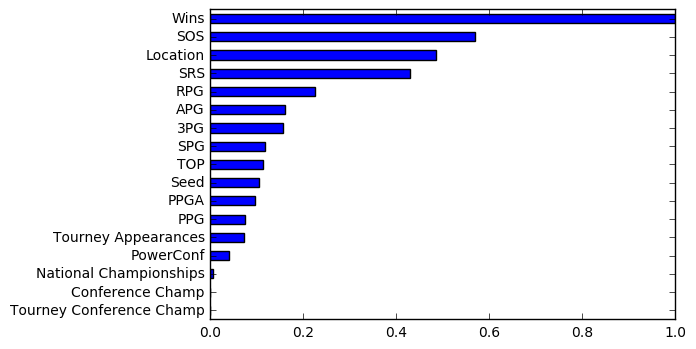

In [49]:
categories=['Wins','PPG','PPGA','PowerConf','3PG', 'APG','TOP','Conference Champ','Tourney Conference Champ',
           'Seed','SOS','SRS', 'RPG', 'SPG', 'Tourney Appearances','National Championships','Location']
accuracy=[]
for i in range(1):
    X_train, X_test, Y_train, Y_test = train_test_split(xTrain, yTrain)
    results1 = model.fit(X_train, Y_train)
    preds1 = model.predict(X_test)
    
    results2 = model2.fit(X_train, Y_train)
    preds2 = model2.predict(X_test)
    
    results3 = model3.fit(X_train, Y_train)
    preds3 = model3.predict(X_test)

    results4 = model4.fit(X_train, Y_train)
    preds4 = model4.predict(X_test)
    
    results5 = model5.fit(X_train, Y_train)
    preds5 = model5.predict(X_test)
    
    preds = (preds1 + preds2 + preds3 + preds4 + preds5)/5

    preds[preds < .5] = 0
    preds[preds >= .5] = 1
    accuracy.append(np.mean(preds == Y_test))
    #accuracy.append(np.mean(predictions == Y_test))
print "The accuracy is", sum(accuracy)/len(accuracy)
showFeatureImportance(categories)

In [50]:
def predictGame(team_1_vector, team_2_vector, home):
    diff = [a - b for a, b in zip(team_1_vector, team_2_vector)]
    diff.append(home)
    preds1 = model.predict([diff])
    preds2 = model2.predict([diff])
    preds3 = model3.predict([diff])
    preds4 = model4.predict([diff])
    preds5 = model5.predict([diff])
    
    preds = (preds1 + preds2 + preds3 + preds4 + preds5)/5
    return preds
    #return model.predict([diff])
    #return model.predict_proba([diff])

In [51]:
team1_vector = getSeasonData(teams_pd[teams_pd['Team_Name'] == 'North Carolina'].values[0][0], 2016)
team2_vector = getSeasonData(teams_pd[teams_pd['Team_Name'] == 'Villanova'].values[0][0], 2016)
predictGame(team1_vector, team2_vector, 0)

array([ 0.19073658])

# Predicting NCAA Tourney 2013 - 2016

For the first stage of the Kaggle competition, our job was to submit probabilities for each of the possible scenarios in the 2013, 2014, 2015, and 2016 tournaments. 

In [52]:
sample_sub_pd = pd.read_csv('sample_submission.csv')
(sample_sub_pd.head())

,id,pred
0,2013_1103_1107,0.5
1,2013_1103_1112,0.5
2,2013_1103_1125,0.5
3,2013_1103_1129,0.5
4,2013_1103_1137,0.5


In [53]:
def createPrediction():
    results = [[0 for x in range(2)] for x in range(len(sample_sub_pd.index))]
    for index, row in sample_sub_pd.iterrows():
        matchup_id = row['id']
        year = matchup_id[0:4]
        team1_id = matchup_id[5:9]
        team2_id = matchup_id[10:14]
        team1_vector = getSeasonData(int(team1_id), int(year))
        team2_vector = getSeasonData(int(team2_id), int(year))
        pred = predictGame(team1_vector, team2_vector, 0)
        results[index][0] = matchup_id
        results[index][1] = pred[0]
        #results[index][1] = pred[0][1]
    results = pd.np.array(results)
    firstRow = [[0 for x in range(2)] for x in range(1)]
    firstRow[0][0] = 'id'
    firstRow[0][1] = 'pred'
    with open("result.csv", "wb") as f:
        writer = csv.writer(f)
        writer.writerows(firstRow)
        writer.writerows(results)

In [54]:
createPrediction()

In [219]:
def findBestK():
    K = (list)(i for i in range(1,200) if i%2!=0)
    p = []
    for k in K:
        kmeans = KNeighborsClassifier(n_neighbors=k)
        kmeans.fit(X_train, Y_train)
        results = kmeans.fit(X_train, Y_train)
        preds = kmeans.predict(X_test)
        p.append(np.mean(preds == Y_test))
    plt.plot(K, p)
    plt.xlabel('k')
    plt.ylabel('Accuracy')
    plt.title('Selecting k with the Elbow Method')
    plt.show()

In [215]:
def neuralNetwork(dim):
    X_train, X_test, Y_train, Y_test = train_test_split(xTrain, yTrain)
    
    model = Sequential()
    model.add(Convolution1D(28, 3, border_mode='same', init='normal', input_shape=(dim, 1))) #28 1D filters of length 3
    model.add(Flatten())
    model.add(Activation('relu'))
    model.add(Dense(64, init='normal'))
    model.add(Activation('relu'))
    model.add(Dense(32, init='normal'))
    model.add(Activation('relu'))
    model.add(Dense(16, init='normal'))
    model.add(Activation('relu'))
    model.add(Dense(2, init='normal'))
    model.add(Activation('softmax'))

   
    X_train = X_train.reshape((len(X_train), dim, 1))
    X_test = X_test.reshape((len(X_test), dim, 1))
    Y_train_categorical = np_utils.to_categorical(Y_train)
    # TRAINING
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, Y_train_categorical, batch_size=64, nb_epoch=5,shuffle=True)
    preds = model.predict(X_test)
    results=[]
    for i in range(preds.shape[0]):
        if preds[i][1] < .5:
            results.append(0)
        else:
            results.append(1)
    print np.mean(results == Y_test)

In [95]:
def getAllTeamVectors():
    year = 2016
    numFeatures = len(getSeasonData(1181,2012))
    teamvecs = np.zeros(( 251, numFeatures ))
    teams=[]
    counter = 0
    for team in teamList:
        team_id = teams_pd[teams_pd['Team_Name'] == team].values[0][0]
        team_vector = getSeasonData(team_id, year)
        if (team_vector[0] == 0 or team_vector[4] == 0):
            continue
        teamvecs[counter] = team_vector
        teams.append(team)
        counter += 1
    team = pd.np.array(teams)
    team = np.reshape(team, (team.shape[0], 1))
    with open("allNames.tsv", "wb") as f:
        writer = csv.writer(f, delimiter='\t')
        writer.writerows(team)
    with open("allVecs.tsv", "wb") as f:
        writer = csv.writer(f, delimiter='\t')
        writer.writerows(teamvecs)
getAllTeamVectors()